##### In this notebook we will try to group the whole code into functions so that it is possible to visualize the frontal probabilities map for both the reanalysis data and the MUR data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cv2
import datetime
import xarray as xr
import os
from pathlib import Path
from scipy.ndimage import gaussian_filter
#plt.rcParams["figure.figsize"] = 10, 8
%matplotlib inline

### Importação dos dados

In [2]:
def get_data(data):
    
    """
    function to get our netCDF file that is stored in the data directory and convert it to a dataframe
    the data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #caso se esteja a importar os dados do MUR, renomear as colunas e passar a temperatura para Celsius
    if data == 'sst_20190725.nc':
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [3]:
df_reanalysis = get_data('IBI2014-2019.nc')   # for Reanalysis data: 'IBI2014-2019.nc'; for MUR: 'sst_20190725.nc'

In [4]:
df_mur = get_data('sst_20190725.nc')

In [5]:
#Não faz sentido ter isto em função

def get_period(df):
    
    """
    Function that receives a dataframe that can have data relative to different days 
    and returns a dictionaire of dataframes (for each different day) and an array with the different dates 
    its possible to find in our dataframe 
    """
    
    specificday = [pd.Timestamp(dd).strftime("%Y-%m-%d %H:%M:%S") for dd in df['time'].unique()]
    specificday = np.array(specificday, dtype=np.object)
  
    #create a dictionary to store the data frames for each day
    days = {elem : pd.DataFrame for elem in specificday}

    for key in days.keys():
        days[key] = df[:][df['time'] == key]
        
    return days, specificday

#after this function we only have to define the period we want to analyse

In [6]:
days_mur, specificday_mur = get_period(df_mur)

In [7]:
days_r, specificday_r = get_period(df_reanalysis)

##### Define the period we want to analyse

Parece-me que a melhor maneira de fazer isto será definir o periodo diretamente à mão (como é feito na linha de baixo)

In [8]:
# period we want to analyse
ond2014_2019 = specificday_r[(specificday_r>='2014-10-01 12:00:00') & (specificday_r <= '2014-12-31 12:00:00') + (specificday_r>='2015-10-01 12:00:00') & (specificday_r <= '2015-12-31 12:00:00')+(specificday_r>='2016-10-01 12:00:00') & (specificday_r <= '2016-12-31 12:00:00')+(specificday_r>='2017-10-01 12:00:00') & (specificday_r <= '2017-12-31 12:00:00')+(specificday_r>='2018-10-01 12:00:00') & (specificday_r <= '2018-12-31 12:00:00')+(specificday_r>='2019-10-01 12:00:00') & (specificday_r <= '2019-12-31 12:00:00')]
ond2014_2019

array(['2014-10-01 12:00:00', '2014-10-02 12:00:00',
       '2014-10-03 12:00:00', '2014-10-04 12:00:00',
       '2014-10-05 12:00:00', '2014-10-06 12:00:00',
       '2014-10-07 12:00:00', '2014-10-08 12:00:00',
       '2014-10-09 12:00:00', '2014-10-10 12:00:00',
       '2014-10-11 12:00:00', '2014-10-12 12:00:00',
       '2014-10-13 12:00:00', '2014-10-14 12:00:00',
       '2014-10-15 12:00:00', '2014-10-16 12:00:00',
       '2014-10-17 12:00:00', '2014-10-18 12:00:00',
       '2014-10-19 12:00:00', '2014-10-20 12:00:00',
       '2014-10-21 12:00:00', '2014-10-22 12:00:00',
       '2014-10-23 12:00:00', '2014-10-24 12:00:00',
       '2014-10-25 12:00:00', '2014-10-26 12:00:00',
       '2014-10-27 12:00:00', '2014-10-28 12:00:00',
       '2014-10-29 12:00:00', '2014-10-30 12:00:00',
       '2014-10-31 12:00:00', '2014-11-01 12:00:00',
       '2014-11-02 12:00:00', '2014-11-03 12:00:00',
       '2014-11-04 12:00:00', '2014-11-05 12:00:00',
       '2014-11-06 12:00:00', '2014-11-07 12:0

In [9]:
july25 = specificday_mur[(specificday_mur =='2019-07-25 09:00:00')]

In [10]:
def canny_creation(days, Tmin, Tmax, sigma=0, apertureSize=3):  
    
    """
    Função que pega numa df com temperaturas relativas a um certo dia e retorna a matriz obtida após 
    aplicação do Canny com a mask para a zona continental
    """
    
    #Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
    Temp = days.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
    
    #Converter os valores de temperatura no formato uint8 com valores entre 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    #if its MUR data we have to apply gaussian filter with certain sigma value (~5)
    Temp_day = gaussian_filter(Temp_day, sigma=sigma)
    
    #apply the canny algorithm and plot the image with the edges
    canny = cv2.Canny(Temp_day, Tmin, Tmax, L2gradient=False, apertureSize=apertureSize)
    
    mask = np.isnan(np.flipud(Temp))    #Boolean array é True onde o array original (Temp) tinha valores Nan
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array cujos pixels= 255 quando mask=True
    #Fazer uma dilatação para assegurar que os pixeis que pertencem à costa não são considerados como frentes no canny
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    canny =np.ma.masked_where(mask_dilated==255, canny)
    
    return canny

Duvida: No caso dos dados do MUR há um problema no calculo da frontal probability. Como se esta a aplicar um gaussian filter, para cada dia diferente os valores do array deixam de variar entre 0-255, passando a variar entre 0-x, ou seja no calculo da frontal probability não podemos dividir por 255.

Depois creio que este x varia de imagem para imagem, portanto não se obteria a probabilidade correta se se dividisse a frontal probability pelo valor máximo que surge no array Temp_day (porque para um dia diferente esse maximo irá variar)

In [11]:
def frontal_prob(period, days, Tmin, Tmax, MUR=False, sigma=0, apertureSize=3):
    """
    Função que retorna um array de shape (121, 169) com a frontal probability de cada pixel
    """
    #if statment to define array shape based on which data it is
    if MUR==False:
        fp = np.zeros((121,169))
    elif MUR==True: 
        fp = np.zeros((1001,1401))
        
    for day in period:
        fp = fp + canny_creation(days[day], Tmin=Tmin, Tmax=Tmax, sigma=sigma, apertureSize=apertureSize)
    
    if sigma ==0:
        fp = fp/(len(period)*255)*100
    elif sigma>=1:
        fp = fp/(len(period))

    
    return fp

In [12]:
def visualization(period, days, Tmin, Tmax, MUR, sigma, apertureSize):
    
    """
    Função para visualizar o map of frontal probability e um histograma com as frontal probabilities
    """
    
    fp = frontal_prob(period=period, days=days, Tmin=Tmin, Tmax=Tmax, MUR=MUR, sigma=sigma, apertureSize=apertureSize)
    
    #fp=jas_data[Tmax]
    
    plt.rcParams["figure.figsize"] = (15, 25)
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    img = ax1.imshow(fp, 'gray') 
    plt.colorbar(img, orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
    plt.title("Map of frontal probability", fontsize=20)

    ax2 = fig.add_subplot(2,1,2)
    ax2.hist(fp.flatten(), bins=100);
    plt.xlabel('Frontal Probability',fontsize=10)
    


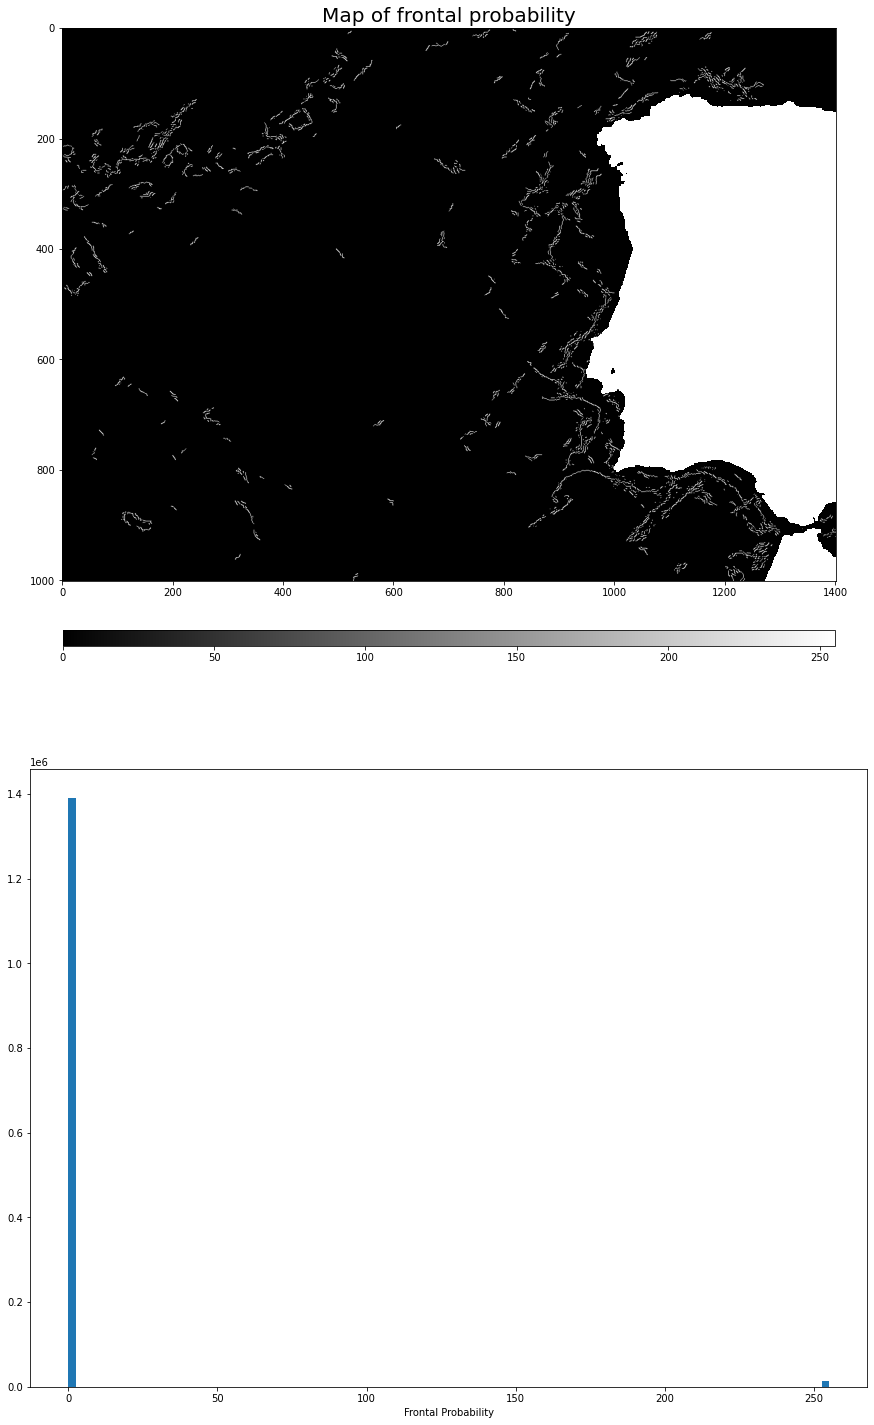

In [15]:
visualization(period = july25, days=days_mur, Tmin=180, Tmax=220, MUR=True, sigma=5, apertureSize=5)